In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import torch
from torchvision import datasets , transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

**A dataset analysis was done in the previous task.**

In [2]:
src_path = "/kaggle/input/animals10/raw-img"
path = "/kaggle/working/raw-img"

shutil.copytree(src_path, path, dirs_exist_ok=True)

'/kaggle/working/raw-img'

In [3]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant",
             "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
             "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "ragno": "spider"}
classes = os.listdir(path)

In [4]:
for category in classes:
    category_path = os.path.join(path, category)
    if os.path.isdir(category_path):
        eng_name = translate.get(category, category)
        eng_path = os.path.join(path, eng_name)
        if eng_name != category:
            os.rename(category_path, eng_path)

In [5]:
transform_data_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_data_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
dataset = datasets.ImageFolder(root=path)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 26179
    Root location: /kaggle/working/raw-img


In [7]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
test_size = int(0.2 * dataset_size)
val_size = dataset_size - train_size - test_size

In [8]:
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

In [9]:
train_dataset = Subset(datasets.ImageFolder(root=path, transform=transform_data_train), train_dataset.indices)
test_dataset = Subset(datasets.ImageFolder(root=path, transform=transform_data_test), test_dataset.indices)
val_dataset = Subset(datasets.ImageFolder(root=path, transform=transform_data_train), val_dataset.indices)

In [25]:
batch_size = 128

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=True, num_workers=4, pin_memory=True)

In [11]:
class ModelCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ModelCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.conv1x1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_out = nn.Linear(128, num_classes)
        
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.conv1x1(x))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)

        return x

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
cnn = ModelCNN().to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

In [15]:
def train_model(model, train_dl, val_dl, device, epochs=50, patience=5):
    loss_function = nn.CrossEntropyLoss()

    best_loss = float('inf')
    patience_counter = 0
    best_model_wts = model.state_dict()

    history = {
        "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []
    }

    for epoch in range(epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_dl)
        epoch_acc = running_corrects / len(train_dl.dataset)
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)

        model.eval()
        val_loss, val_corrects = 0.0, 0

        with torch.no_grad():
            for val_inputs, val_labels in val_dl:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = loss_function(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_loss += loss.item()
                val_corrects += torch.sum(val_preds == val_labels.data).item()

        val_epoch_loss = val_loss / len(val_dl)
        val_epoch_acc = val_corrects / len(val_dl.dataset)
        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_epoch_acc)

        print(f"""Epoch {epoch+1}/{epochs}\nTrain Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}\nVal Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}""")

#        if val_epoch_loss < best_loss:
#            best_loss = val_epoch_loss
#            patience_counter = 0
#            best_model_wts = model.state_dict()
#        else:
#            patience_counter += 1

#        if patience_counter >= patience:
#            break

    model.load_state_dict(best_model_wts)
    return model, history

In [16]:
trained_model, history = train_model(cnn, train_dl, val_dl, device, epochs=30, patience=5)

Epoch 1/30
Train Loss: 2.0891, Train Acc: 0.3025
Val Loss: 1.6714, Val Acc: 0.4160
Epoch 2/30
Train Loss: 1.4826, Train Acc: 0.4880
Val Loss: 1.3771, Val Acc: 0.5265
Epoch 3/30
Train Loss: 1.2992, Train Acc: 0.5542
Val Loss: 1.2377, Val Acc: 0.5570
Epoch 4/30
Train Loss: 1.1897, Train Acc: 0.5918
Val Loss: 1.1420, Val Acc: 0.6092
Epoch 5/30
Train Loss: 1.0977, Train Acc: 0.6303
Val Loss: 1.0997, Val Acc: 0.6227
Epoch 6/30
Train Loss: 1.0008, Train Acc: 0.6595
Val Loss: 1.0807, Val Acc: 0.6390
Epoch 7/30
Train Loss: 0.9535, Train Acc: 0.6769
Val Loss: 0.9717, Val Acc: 0.6766
Epoch 8/30
Train Loss: 0.8804, Train Acc: 0.7047
Val Loss: 1.0432, Val Acc: 0.6521
Epoch 9/30
Train Loss: 0.8093, Train Acc: 0.7252
Val Loss: 0.9795, Val Acc: 0.6737
Epoch 10/30
Train Loss: 0.7631, Train Acc: 0.7430
Val Loss: 1.0336, Val Acc: 0.6600
Epoch 11/30
Train Loss: 0.7247, Train Acc: 0.7567
Val Loss: 0.9165, Val Acc: 0.6946
Epoch 12/30
Train Loss: 0.6747, Train Acc: 0.7717
Val Loss: 0.9808, Val Acc: 0.6884
E

In [17]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(history['train_loss'], label='Train Loss')
    ax[0].plot(history['val_loss'], label='Val Loss')
    ax[0].set_title('Loss per Epoch')
    ax[0].legend()

    ax[1].plot(history['train_acc'], label='Train Acc')
    ax[1].plot(history['val_acc'], label='Val Acc')
    ax[1].set_title('Accuracy per Epoch')
    ax[1].legend()


    plt.show()

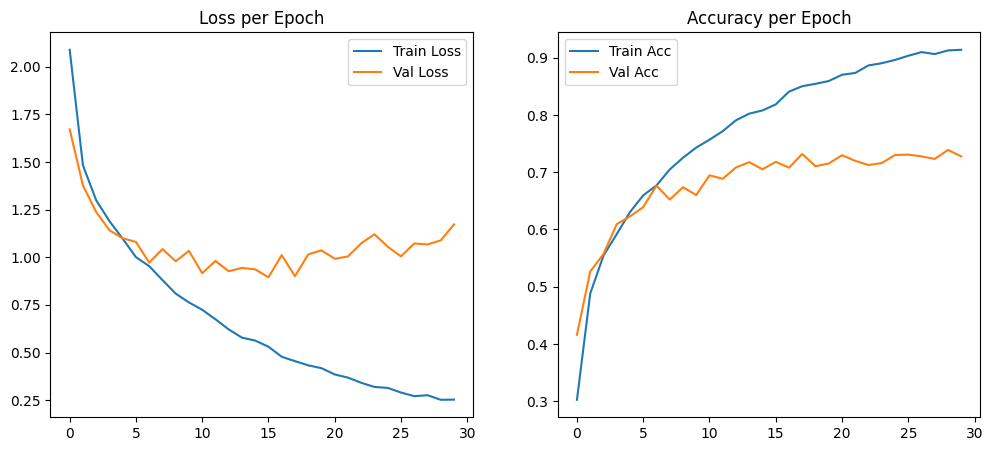

In [18]:
plot_training_history(history)

In [19]:
def evaluate_model(model, test_dl, device):
    model.eval()
    all_preds, all_labels = [], []
    class_names = dataset.classes

    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Test Accuracy: 0.7022
Classification Report:
              precision    recall  f1-score   support

   butterfly       0.80      0.79      0.80       186
         cat       0.56      0.41      0.47       163
     chicken       0.76      0.81      0.79       311
         cow       0.60      0.60      0.60       187
         dog       0.63      0.74      0.68       495
    elephant       0.87      0.50      0.63       145
       horse       0.73      0.67      0.70       285
       sheep       0.62      0.54      0.57       177
      spider       0.78      0.88      0.83       478
    squirrel       0.67      0.59      0.63       192

    accuracy                           0.70      2619
   macro avg       0.70      0.65      0.67      2619
weighted avg       0.70      0.70      0.70      2619



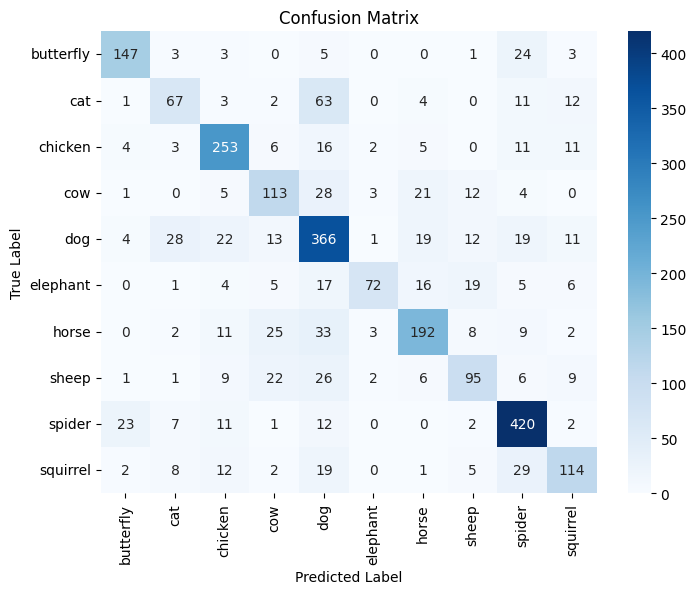

In [20]:
evaluate_model(trained_model, test_dl, device)

In [24]:
new_path = '/kaggle/working/cnn-animal10.pth'
torch.save(trained_model.state_dict(), new_path)